# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [1]:
# Load pickled data
import pickle
import numpy as np
from sklearn.model_selection import train_test_split
import cv2
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow.contrib.layers import flatten

training_file = 'train.p'
testing_file = 'test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)

X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']
    
assert(len(X_train) == len(y_train))
assert(len(X_test) == len(y_test))

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 2D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below.

In [2]:
# Collect some information about the training set
def collect_information_training_set(data_set_labels):
    count_biggest_class = 0
    total_number_images_unmod = 0
    w, h = 3, 43 
    info_classes_in = [[0 for x in range(w)] for y in range(h)] 

    # Set the class IDs in the first column
    for i in range(0, len(info_classes_in)):
        info_classes_in[i][0] = i

    # Count the number of images per class and write it in the second and third column
    for i in range(len(data_set_labels)):
        count = int(data_set_labels[i])
        info_classes_in[int(count)][1] += 1
        info_classes_in[int(count)][2] += 1

    # Find the class with the most images
    for i in range(0, len(info_classes_in)):
        if info_classes_in[i][1] > count_biggest_class:
            count_biggest_class = info_classes_in[i][1]
    return info_classes_in, count_biggest_class

def print_dataset_information(training_features, training_labels, test_features, test_labels):
    # Number of training examples
    n_train = len(training_features)

    # Number of testing examples.
    n_test = len(test_features)

    # What's the shape of an traffic sign image?
    image_shape = training_features[0].shape

    # How many unique classes/labels there are in the dataset.
    distinctmyList =[]
    a_list=[]
    y_dataset = np.concatenate((training_labels, test_labels), axis=0)

    for i in y_dataset:
        a_list.append(i)
    distinctmyList.append(list(set(a_list)))
    n_classes = len(distinctmyList[0])

    print("Number of training images:")
    print("Value: ", n_train)
    print("\nNumber of testing images:")
    print("Value: ", n_test)
    print("\nImage data shape:")
    print("Value: ", image_shape)
    print("\nNumber of classes:")
    print("Value: ", n_classes)
    
def print_class_information(info_classes_in):
    # Maximum images per class
    print("Maximum images per class: ", count_biggest_class)

    # Show information per class (each row is one class)
    for i in range(0, len(info_classes_in)):
        print('ClassID: ' + str(info_classes_in[i][0]) + '    number images : ' + str(info_classes_in[i][1]))

print_dataset_information(X_train, y_train, X_test, y_test)

Number of training images:
Value:  39209

Number of testing images:
Value:  12630

Image data shape:
Value:  (32, 32, 3)

Number of classes:
Value:  43


Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections.

2


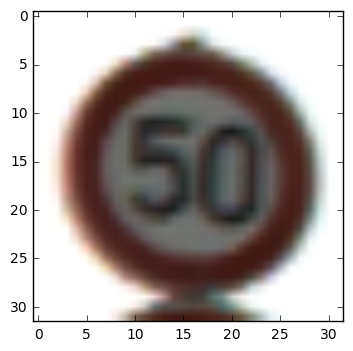

In [3]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.
import random
import matplotlib.pyplot as plt
# Visualizations will be shown in the notebook.
%matplotlib inline

def show_random_image(img_pack, label_pack, color):
    # print a random image of a img_pack and its label
    index = random.randint(0, len(img_pack))
    image = img_pack[index].squeeze()
    #plt.figure(figsize=(1,1))
    if color == 1:
        plt.imshow(image)
    else:
        plt.imshow(image, cmap='gray')
    print(label_pack[index])
    
# print a random image of a img_pack and its label
show_random_image(X_train, y_train, 1)

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

**NOTE:** The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play!

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

34


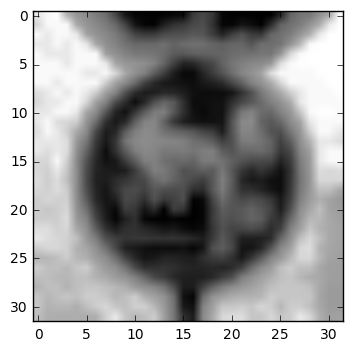

In [4]:
### Preprocess the data here.
### Feel free to use as many code cells as needed.

def preprocess_images(img_array):
    new_array = []
    for i in range(len(img_array)):
        # Change to grayscale
        image_mod_1 = cv2.cvtColor(img_array[i], cv2.COLOR_RGB2GRAY)
        # Equalize the histogram
        image_mod_2 = cv2.equalizeHist(image_mod_1)
        # Normalize the values (-1 to 1)
        image_mod_3 = image_mod_2/127.5 - 1
        new_array.append(image_mod_3)
    new_array = np.array(new_array).reshape((-1,32,32,1))
    return new_array

# Preprocess training data
X_train = preprocess_images(X_train)

# Preprocess test data
X_test = preprocess_images(X_test)
    
# Show random image of training data (grayscaled image)
show_random_image(X_train, y_train, 0)

3


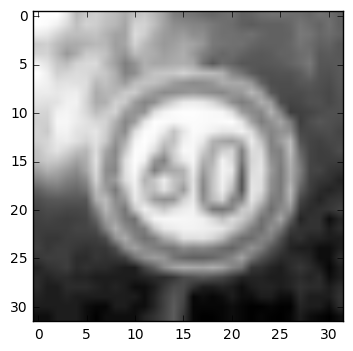

In [5]:
# Show random image of test data (grayscaled image)
show_random_image(X_test, y_test, 0)

### Question 1 

_Describe how you preprocessed the data. Why did you choose that technique?_

**Answer:**

TODO !!!!!!!!!

Shape: (32, 32)


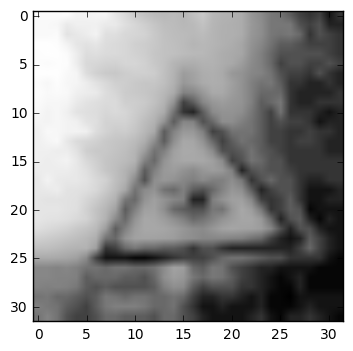

In [6]:
#Generate data additional data
        
# TODO rewrite it:
# code found here https://github.com/vxy10/ImageAugmentation/blob/master/img_transform_NB.ipynb
# https://medium.com/@vivek.yadav/dealing-with-unbalanced-data-generating-additional-data-by-jittering-the-original-image-7497fe2119c3#.wlzus6b12
def transform_image(img,ang_range,shear_range,trans_range):
    '''
    This function transforms images to generate new images.
    The function takes in following arguments,
    1- Image
    2- ang_range: Range of angles for rotation
    3- shear_range: Range of values to apply affine transform to
    4- trans_range: Range of values to apply translations over. 
    
    A Random uniform distribution is used to generate different parameters for transformation
    
    '''
    # Rotation
    ang_rot = np.random.uniform(ang_range)-ang_range/2
    rows,cols,ch = img.shape    
    Rot_M = cv2.getRotationMatrix2D((cols/2,rows/2),ang_rot,1)

    # Translation
    tr_x = trans_range*np.random.uniform()-trans_range/2
    tr_y = trans_range*np.random.uniform()-trans_range/2
    Trans_M = np.float32([[1,0,tr_x],[0,1,tr_y]])

    # Shear
    pts1 = np.float32([[5,5],[20,5],[5,20]])

    pt1 = 5+shear_range*np.random.uniform()-shear_range/2
    pt2 = 20+shear_range*np.random.uniform()-shear_range/2
    
    # Brightness 
    pts2 = np.float32([[pt1,5],[pt2,pt1],[5,pt2]])

    shear_M = cv2.getAffineTransform(pts1,pts2)
        
    img = cv2.warpAffine(img,Rot_M,(cols,rows))
    img = cv2.warpAffine(img,Trans_M,(cols,rows))
    img = cv2.warpAffine(img,shear_M,(cols,rows))
    
    return img

def get_random_image(img_pack):
    # print a random image of a img_pack and its label
    index = random.randint(0, len(img_pack))
    image = img_pack[index].squeeze()       
    return image
        
# Only for testing -> Default is 0, set to 1 to test
test_debug = 1
if test_debug == 1:
    testimage = get_random_image(X_train)
    # What's the shape of an traffic sign image?
    testimage_shape = testimage.shape
    print('Shape: ' + str(testimage_shape))
    plt.imshow(testimage, cmap='gray')

Shape: (32, 32, 1)


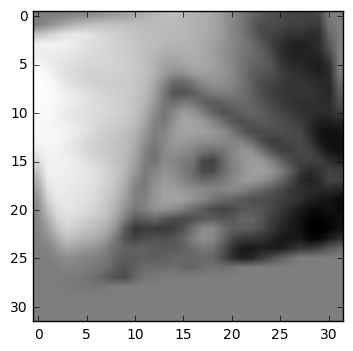

In [7]:
# Only for testing -> see above
if test_debug == 1:
    modtest = testimage.reshape((32,32,1))
    modtest_shape = modtest.shape
    print('Shape: ' + str(modtest_shape))
    modimage = transform_image(modtest,10,5,2)
    plt.imshow(modimage, cmap='gray')

In [8]:
# Generate / Load more data (augmented data)
# IMPORTANT: 
# In this cell, additional data can be added to X_train and y_train
# or
# already *.p with stored additional data (generated with the following code) can be loaded
# This is done because generating data takes a lot of time
# or
# the original training data (from Udacity) can be used

# Set the configuration variable to decide what to do
# generate_additional_data = 1 --> new data is generated and added to X_train and y_train
# load_additional_data = 1 AND generate_additional_data != 1 --> data is loaded from *.p and filled into X_train and y_train
# generate_additional_data = 0 AND load_additional_data = 0 --> the original training data (from Udacity) is used
# generate_additional_data = 1 AND load_additional_data = 1 --> new data is generated and added to X_train and y_train

generate_additional_data = 0
load_additional_data = 1
filename_to_store_load = 'train_extended_1.p'

# Generate new data
if generate_additional_data == 1: 
    images_sum = 0
    # Counts to print a is-alive message in the notebook while generating additional data
    count1 = 0
    count2 = 0

    # Set to 1 if you really want to generate extra data (images+labels) ---> needs much time
    # Set to 0 if only for testing
    really_generate_images = 1
    really_generate_labels = 1

    # Define the number of images which every class should have (TODO edit for final solution)
    #min_images_per_class = count_biggest_class
    min_images_per_class = 500

    # Collect some information about the original training set (from Udacity)
    info_classes, count_biggest_class = collect_information_training_set(y_train)
    
    print(X_train.shape)
    print(y_train.shape)
    for x in range(0, len(X_train)):
        #print('ClassID: ' + str(y_train[x]))
        images_per_class = info_classes[int(y_train[x])][1]
        #print('Images per Class: ' + str(images_per_class))
        images_to_generate = int(round(((min_images_per_class - images_per_class) / images_per_class),0))
        if images_to_generate == 0:
            if info_classes[int(y_train[x])][2] < min_images_per_class:
                images_to_generate = 1
        if info_classes[int(y_train[x])][2] >= min_images_per_class:
            images_to_generate = 0
        #print('Images to generate: ' + str(images_to_generate))
        images_sum = images_sum + images_to_generate
        for i in range(0, images_to_generate):
            # Count to print progress-data
            count2 += 1
            if count2 > 100:
                count2 = 0
                count1 += 1
                printcount = count1 * 100
                print('Generated images so far: ' + str(printcount))
            if really_generate_images == 1:
                # Generate the new image and add to X_train
                new_array = []
                image_in = X_train[x]
                #image_out = transform_image(image_in,20,10,5)
                image_out = transform_image(image_in,10,5,2)
                new_array.append(image_out)
                new_array = np.array(new_array).reshape((-1,32,32,1))
                X_train = np.vstack((X_train, new_array))
            if really_generate_labels == 1:
                # Generate the new label and add to y_train
                new_class = y_train[x]
                y_extra = np.zeros( 1 )
                y_extra[0] = int(np.ones( ( 1, ) ) * new_class)
                y_train = np.concatenate( (y_train, y_extra), axis=0 )
            info_classes[int(y_train[x])][2] += 1

    print('Images and labels generated total: ' + str(images_sum)) 
    print(X_train.shape)
    print(y_train.shape)
    
    # Store new X_train and y_train in a pickle file
    pickle.dump({
            "features" : X_train,
            "labels" : y_train
        }, open(filename_to_store_load, "wb" ) )
    
    print()
    print('Data stored to: ' + str(filename_to_store_load))

# load_additional_data = 0 AND generate_additional_data != 1--> Load data from *.p
elif load_additional_data == 1 and generate_additional_data != 1: 
    with open(filename_to_store_load, mode='rb') as f:
        train = pickle.load(f)

    X_train, y_train = train['features'], train['labels']

    assert(len(X_train) == len(y_train))
    print()
    print('Data loaded from: ' + filename_to_store_load)
# 
else:
    print("The original training data (from Udacity) is used")


Data loaded from: train_extended_1.p


In [9]:
# Print some information about the training data
print_dataset_information(X_train, y_train, X_test, y_test)

Number of training images:
Value:  42419

Number of testing images:
Value:  12630

Image data shape:
Value:  (32, 32, 1)

Number of classes:
Value:  43


In [10]:
# Collect some information about the training data (class-distribution)
info_classes, count_biggest_class = collect_information_training_set(y_train)

# Total number of images
total_number_images_mod = len(X_train)
print("Total number of training images: ", total_number_images_mod)

# Print some information about the training set
print_class_information(info_classes)

Total number of training images:  42419
Maximum images per class:  2250
ClassID: 0    number images : 420
ClassID: 1    number images : 2220
ClassID: 2    number images : 2250
ClassID: 3    number images : 1410
ClassID: 4    number images : 1980
ClassID: 5    number images : 1860
ClassID: 6    number images : 500
ClassID: 7    number images : 1440
ClassID: 8    number images : 1410
ClassID: 9    number images : 1470
ClassID: 10    number images : 2010
ClassID: 11    number images : 1320
ClassID: 12    number images : 2100
ClassID: 13    number images : 2160
ClassID: 14    number images : 780
ClassID: 15    number images : 630
ClassID: 16    number images : 500
ClassID: 17    number images : 1110
ClassID: 18    number images : 1200
ClassID: 19    number images : 420
ClassID: 20    number images : 500
ClassID: 21    number images : 500
ClassID: 22    number images : 500
ClassID: 23    number images : 510
ClassID: 24    number images : 500
ClassID: 25    number images : 1500
ClassID: 26  

42.0


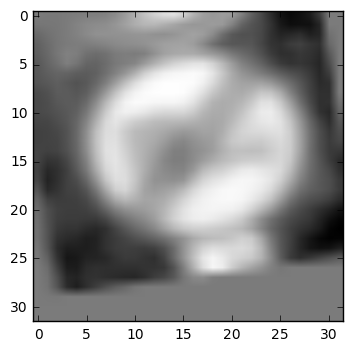

In [11]:
# Only for testing issues -> Delete
timage = X_train[len(X_train)-10].squeeze()       
plt.imshow(timage, cmap='gray')
tlabel = y_train[len(X_train)-10]
t_label = int(tlabel)
print(tlabel)

In [12]:
# Split the data into training/validation/testing sets here.

# Split up the training data to get validation data
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

assert(len(X_train) == len(y_train))
assert(len(X_validation) == len(y_validation))

# Number of training examples
n_train = len(X_train)

# Number of testing examples.
n_test = len(X_test)

# Number of validation examples.
n_validation = len(X_validation)

# What's the shape of an traffic sign image?
image_shape = X_train[0].shape

# How many unique classes/labels there are in the whole dataset.
distinctmyList =[]
a_list=[]
y_dataset = np.concatenate((y_train, y_test, y_validation), axis=0)

for i in y_dataset:
    a_list.append(i)
distinctmyList.append(list(set(a_list)))
n_classes = len(distinctmyList[0])

print("Number of training examples =", n_train)
print("Number of validation examples =", n_validation)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 33935
Number of validation examples = 8484
Number of testing examples = 12630
Image data shape = (32, 32, 1)
Number of classes = 43


### Question 2

_Describe how you set up the training, validation and testing data for your model. **Optional**: If you generated additional data, how did you generate the data? Why did you generate the data? What are the differences in the new dataset (with generated data) from the original dataset?_

**Answer:**

TODO !!!

In [13]:
### Define your architecture here.
### Feel free to use as many code cells as needed.

# Shuffle training and validation data
X_train, y_train = shuffle(X_train, y_train)
X_validation, y_validation = shuffle(X_validation, y_validation)

EPOCHS = 120
BATCH_SIZE = 128

def gadaNet(x, keep_prob):    
    # Hyperparameters
    mu = 0
    sigma = 0.1
    
    # Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 1, 6), mean = mu, stddev = sigma), name='weights_conv1')
    conv1_b = tf.Variable(tf.zeros(6), name='bias_conv1')
    conv1_op   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID', name='op_conv1') + conv1_b

    # Activation.
    conv1_act = tf.nn.relu(conv1_op, name='act_conv1')

    # Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1_pool = tf.nn.max_pool(conv1_act, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID', name='max_pool_conv1')
    
    # Dropout.
    conv1_drop = tf.nn.dropout(conv1_pool, keep_prob, name='conv1_drop')

    # Layer 2: Convolutional. Output = 10x10x16.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma), name='weights_conv2')
    conv2_b = tf.Variable(tf.zeros(16), name='bias_conv2')
    conv2_op   = tf.nn.conv2d(conv1_drop, conv2_W, strides=[1, 1, 1, 1], padding='VALID', name='op_conv2') + conv2_b
    
    # Activation.
    conv2_act = tf.nn.relu(conv2_op, name='act_conv2')

    # Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2_pool = tf.nn.max_pool(conv2_act, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID', name='max_pool_conv2')

    # Dropout.
    conv2_drop = tf.nn.dropout(conv2_pool, keep_prob, name='conv2_drop')
    
    # Flatten. Input = 5x5x16. Output = 400.
    fc0   = flatten(conv2_drop)
    
    # Layer 3: Fully Connected. Input = 400. Output = 120.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(400, 120), mean = mu, stddev = sigma), name='weights_fc1')
    fc1_b = tf.Variable(tf.zeros(120), name='bias_fc1')
    fc1_op   = tf.matmul(fc0, fc1_W, name='op_fc1') + fc1_b
    
    # Activation.
    fc1_act    = tf.nn.relu(fc1_op, name='act_fc1')
    
    # Dropout.
    fc1_drop = tf.nn.dropout(fc1_act, keep_prob, name='fc1_drop')

    # Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma), name='weights_fc2')
    fc2_b  = tf.Variable(tf.zeros(84), name='bias_fc2')
    fc2_op    = tf.matmul(fc1_drop, fc2_W, name='op_fc2') + fc2_b
    
    # Activation.
    fc2_act    = tf.nn.relu(fc2_op, name='act_fc2')
    
    # Dropout.
    fc2_drop = tf.nn.dropout(fc2_act, keep_prob, name='fc2_drop')

    # Layer 5: Fully Connected. Input = 84. Output = 43.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, 43), mean = mu, stddev = sigma), name='weights_fc3')
    fc3_b  = tf.Variable(tf.zeros(43), name='bias_fc3')
    logits = tf.matmul(fc2_drop, fc3_W, name='op_fc3') + fc3_b
    
    return logits

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**

TODO !!!!

In [14]:
### Train your model here.
### Feel free to use as many code cells as needed.

x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))
keep_prob = tf.placeholder( tf.float32, name='keep_prob')
one_hot_y = tf.one_hot(y, 43)

# Training pipeline
rate = 0.001

logits = gadaNet(x, keep_prob)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

# Evaluation Pipeline

# Model Evaluation
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# Evaluate Accuracy
def evaluate_accuracy_loss(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    total_loss = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy, loss = sess.run([accuracy_operation, loss_operation], feed_dict={x: batch_x, y: batch_y, keep_prob: 1})
        total_accuracy += (accuracy * len(batch_x))
        total_loss += (loss * len(batch_x) )
    return [total_accuracy / num_examples, total_loss/num_examples]

In [15]:
# Train the model
saver = tf.train.Saver()

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    #tf.reset_default_graph()
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 0.5})
            
        validation_accuracy, validation_loss = evaluate_accuracy_loss(X_validation, y_validation)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print("Validation Loss = {:.3f}".format(validation_loss))
        print()
        
    saver.save(sess, 'gadaNet')
    print("Model saved")

Training...

EPOCH 1 ...
Validation Accuracy = 0.244
Validation Loss = 3.005

EPOCH 2 ...
Validation Accuracy = 0.432
Validation Loss = 1.929

EPOCH 3 ...
Validation Accuracy = 0.535
Validation Loss = 1.545

EPOCH 4 ...
Validation Accuracy = 0.637
Validation Loss = 1.346

EPOCH 5 ...
Validation Accuracy = 0.681
Validation Loss = 1.140

EPOCH 6 ...
Validation Accuracy = 0.699
Validation Loss = 1.042

EPOCH 7 ...
Validation Accuracy = 0.727
Validation Loss = 0.960

EPOCH 8 ...
Validation Accuracy = 0.745
Validation Loss = 0.910

EPOCH 9 ...
Validation Accuracy = 0.746
Validation Loss = 0.872

EPOCH 10 ...
Validation Accuracy = 0.768
Validation Loss = 0.827

EPOCH 11 ...
Validation Accuracy = 0.790
Validation Loss = 0.780

EPOCH 12 ...
Validation Accuracy = 0.795
Validation Loss = 0.743

EPOCH 13 ...
Validation Accuracy = 0.793
Validation Loss = 0.722

EPOCH 14 ...
Validation Accuracy = 0.812
Validation Loss = 0.691

EPOCH 15 ...
Validation Accuracy = 0.811
Validation Loss = 0.671

EPOCH 

### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**

TODO !!!!

### Question 5


_What approach did you take in coming up with a solution to this problem? It may have been a process of trial and error, in which case, outline the steps you took to get to the final solution and why you chose those steps. Perhaps your solution involved an already well known implementation or architecture. In this case, discuss why you think this is suitable for the current problem._

**Answer:**

TODO !!!!!!

In [16]:
# Test the model with test-data
# Shuffle the test-set
X_test, y_test = shuffle(X_test, y_test)

new_saver = tf.train.import_meta_graph('gadaNet.meta')

with tf.Session() as sess:
    new_saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy, test_loss = evaluate_accuracy_loss(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))
    print("Test Loss = {:.3f}".format(test_loss))
    print()

Test Accuracy = 0.889
Test Loss = 0.423



---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [ ]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It could be helpful to plot the images in the notebook._



**Answer:**

In [ ]:
### Run the predictions here.
### Feel free to use as many code cells as needed.

### Question 7

_Is your model able to perform equally well on captured pictures when compared to testing on the dataset? The simplest way to do this check the accuracy of the predictions. For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate._

_**NOTE:** You could check the accuracy manually by using `signnames.csv` (same directory). This file has a mapping from the class id (0-42) to the corresponding sign name. So, you could take the class id the model outputs, lookup the name in `signnames.csv` and see if it matches the sign from the image._


**Answer:**

In [ ]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

**Answer:**

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.